Preprocessing
*Load data
*Visual inspection (bad channels)
*Filtering (low + high pass)
*Artefact remove (ICA?)
*Epoching (trigger values on last slide from yesterday, including base-line correcting - tmin = time before stim = 0.5s, tmax = time after stim = 1.5s, baseline = (None,0) = gives the entire baseline as a baseline)
*(once you have epochs you can start plotting - two things he said remember to plot the...)
*Reject based on values

no bad channels for participant 2 (next data file)
20 = trial go?
10 = response?

In [1]:
#%matplotlib qt
%matplotlib inline

In [2]:
import mne
import pandas as pd
import os
import numpy as np

## Load data

In [3]:
#Loading data
filepath = os.path.join("..", "..", "EEG_data", "p1-raw.fif")
raw = mne.io.read_raw_fif(filepath, preload=True)
raw.load_data()

Opening raw data file ..\..\EEG_data\p1-raw.fif...
    Range : 0 ... 1214579 =      0.000 ...  1214.579 secs
Ready.
Reading 0 ... 1214579  =      0.000 ...  1214.579 secs...


<Raw | p1-raw.fif, 32 x 1214580 (1214.6 s), ~296.6 MB, data loaded>

## Filtering

In [5]:
#Low pass filter first, then high pass filter (instead of both at the same time, which can produce more artifacts)
#creating a copy in order to still have the basic "raw" unchanged
raw_filtered = raw.copy().filter(l_freq=None, h_freq=40)
raw_filtered = raw_filtered.filter(l_freq=0.1, h_freq=None)

Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 331 samples (0.331 sec)

Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 0.1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Filter length: 33001 samples (33.001 sec)



In [6]:
#Checking if filtered as wanted
raw_filtered.info

<Info | 12 non-empty values
 bads: []
 ch_names: Fp1, Fp2, F7, F3, Fz, F4, F8, FC5, FC1, FC2, FC6, T7, C3, Cz, ...
 chs: 32 EEG
 custom_ref_applied: False
 description: Anonymized using a time shift to preserve age at acquisition
 dig: 35 items (3 Cardinal, 32 EEG)
 experimenter: mne_anonymize
 file_id: 4 items (dict)
 highpass: 0.1 Hz
 lowpass: 40.0 Hz
 meas_date: 2000-01-01 00:00:00 UTC
 meas_id: 4 items (dict)
 nchan: 32
 projs: []
 sfreq: 1000.0 Hz
>

## Artifact corrections

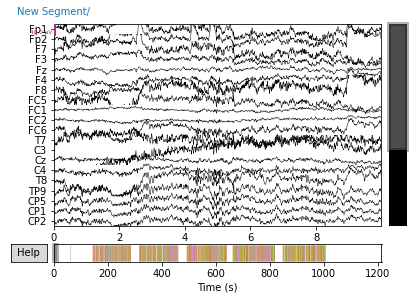

In [7]:
#looking at the channels
raw_filtered.plot();
#c3 looks bad, F8, F7 looks like they have artifacts

In [8]:
#defining C3 as a bad channe
raw_filtered.info['bads'].append('C3')

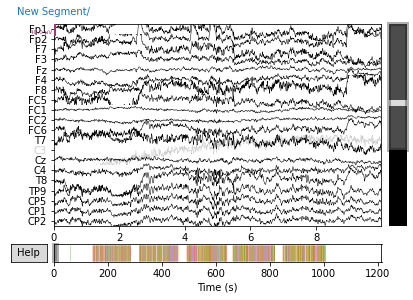

In [9]:
#plot channels after marking C3 as bad (now grey)
raw_filtered.plot();

In [10]:
# set up and fit the ICA - as many components as needed for explaining 95% of the variance - to detect noise
ica = mne.preprocessing.ICA(n_components=0.95, random_state=97, max_iter=800)
ica.fit(raw_filtered)

Fitting ICA to data using 31 channels (please be patient, this may take a while)
Selecting by explained variance: 11 components
Fitting ICA took 16.5s.


<ICA | raw data decomposition, fit (fastica): 1214580 samples, 11 components, channels used: "eeg">

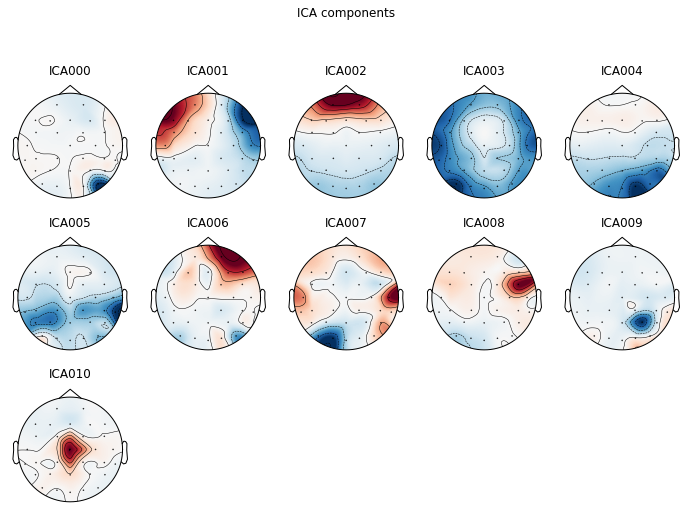

In [11]:
# Visualising components ordered by the variance that they explain (most = first)
ica.plot_components();

# These components are accumulated across time and channels - grouping components, that look alike.

Creating RawArray with float64 data, n_channels=11, n_times=1214580
    Range : 0 ... 1214579 =      0.000 ...  1214.579 secs
Ready.


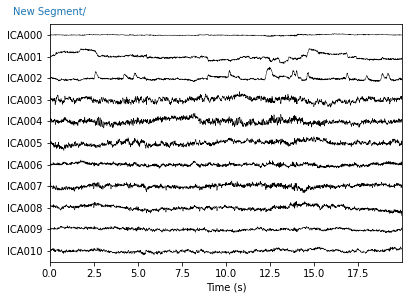

In [53]:
#Plotting the time series of the ICA (plotting the components - also to detect artifacts)
ica.plot_sources(raw_filtered, show_scrollbars=False);

    Using multitaper spectrum estimation with 7 DPSS windows
Not setting metadata
Not setting metadata
607 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Not setting metadata
Not setting metadata
607 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Not setting metadata
Not setting metadata
607 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped


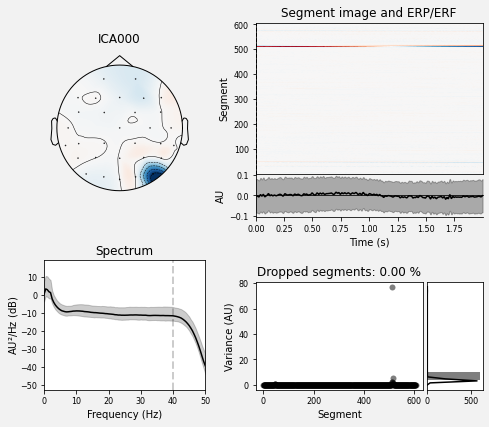

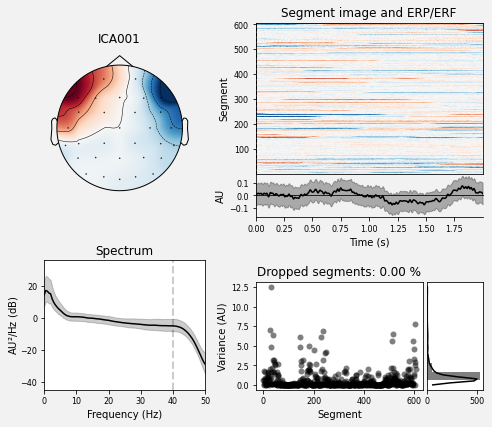

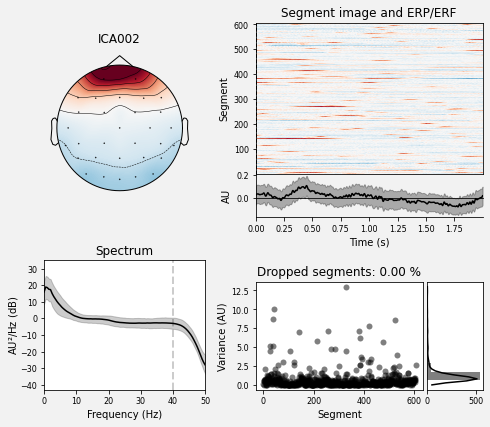

[<Figure size 504x432 with 6 Axes>,
 <Figure size 504x432 with 6 Axes>,
 <Figure size 504x432 with 6 Axes>]

In [54]:
#Plotting properties of the components we want to exclude
#Excluding 000 = muscle tensions, 001 = saccade, 002 = eye blink
ica.exclude = [0, 1, 2]
ica.plot_properties(raw_filtered, picks=ica.exclude)

In [55]:
#Applying the ICA
orig_raw = raw_filtered.copy() #making a copy first, since it changes the data to apply the ica
#raw.load_data() #might not be needed as we did preload = True earlier

#Applying the ICA (ow that the exclusions have been set, we can reconstruct the sensor signals
# with artifacts removed using the apply method)
ica.apply(raw_filtered)

Applying ICA to Raw instance
    Transforming to ICA space (11 components)
    Zeroing out 3 ICA components
    Projecting back using 31 PCA components


<Raw | p1-raw.fif, 32 x 1214580 (1214.6 s), ~296.6 MB, data loaded>

## Events/Epochs

In [61]:
# Defining events
events, _ = mne.events_from_annotations(raw)
print(events)
print(_)
#sample number in the first column and integer event ID in the last column;

Non-RawBrainVision raw using branvision markers
Used Annotations descriptions: ['New Segment/', 'Stimulus/S  1', 'Stimulus/S 10', 'Stimulus/S 11', 'Stimulus/S 12', 'Stimulus/S 20']
[[      0       0   99999]
 [  60957       0      10]
 [ 142467       0       1]
 ...
 [1002958       0      10]
 [1003258       0       1]
 [1004718       0      12]]
{'New Segment/': 99999, 'Stimulus/S  1': 1, 'Stimulus/S 10': 10, 'Stimulus/S 11': 11, 'Stimulus/S 12': 12, 'Stimulus/S 20': 20}


In [62]:
#we can provide an event dictionary that maps the integer IDs to experimental conditions or events
event_id = {'S20': 20, 'S11': 11, 'S10': 10}

In [63]:
# Rejection parameters based on peak-to-peak amplitude
reject = dict(eeg=150e-6)  # 150 µV

# Any signal greater than 150 µV cannot be generated by a brain, thus a data quality constraint
# rejecting any epoch where peak-to-peak signal amplitude is beyond reasonable limits for that channel type.

In [67]:
# Creating epochs
epochs = mne.Epochs(raw_filtered, events, event_id, tmin=-0.5, tmax=1.5,
                    baseline=(None,0), reject=reject, preload=True)

# We specify tmin = -0.5 and tmax = 1.5 (the time relative to each event at which to start and end each epoch).
# And put in the reject parameters based on peak-to-peak amplitude (defined above)

Not setting metadata
Not setting metadata
439 matching events found
Setting baseline interval to [-0.5, 0.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 439 events and 2001 original time points ...
    Rejecting  epoch based on EEG : ['P8', 'O2']
    Rejecting  epoch based on EEG : ['P4']
    Rejecting  epoch based on EEG : ['P4']
    Rejecting  epoch based on EEG : ['TP10']
4 bad epochs dropped


In [69]:
epochs

Number of events,435
Events,S10: 238S11: 98S20: 99
Time range,-0.500 – 1.500 sec
Baseline,-0.500 – 0.000 sec


## Visualisation

In [70]:
#Trying to plot the events
mne.viz.plot_events(events[:50], sfreq=250, first_samp=raw.first_samp, event_id=event_id);
#mne.viz.plot_events(events, event_id=event_dict, sfreq=raw.info['sfreq'],
                          first_samp=raw.first_samp)

IndentationError: unexpected indent (<ipython-input-70-6e1806624e65>, line 4)